<a href="https://colab.research.google.com/github/tsandovalr/RNN-PulmonaryDiagnosis/blob/main/RNN_Pulmonary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import os
import librosa
import math 
import json
from pprint import pprint
from tqdm import tqdm
DATASET_PATH = "./RNN-DATA"
JSON_PATH = "./data-prueba.json"
SAMPLE_RATE = 22050
DURATION = 16 #measured by seconds 
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
def save_mfcc(dataset_path,json_path, n_mfcc=13,n_fft=2048,hop_length=512, num_segments=5):
  # dictionary to store data 
  # data = {
  #     "mapping" : ["healthy","COPD"],
  #     "mfcc" : [ [...], [...], [...]  ],
  #     "labels" : [0,0,1],
  # }

  data = {
      "mapping" : [],
      "mfcc" : [],
      "labels" : [],
  }

  num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
  expected_n_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

  for i, (dirpath,dirname,filenames) in (enumerate(os.walk(dataset_path))):
    # ensure we are not at the root level
    if (dirpath) is not dataset_path:
      #Save the semantic label
      dirpath_components = dirpath.split('/') # genre/healthy = ["genre", "healthy"]
      semantic_label = dirpath_components[-1]
      data["mapping"].append(semantic_label)
      
      pprint(f"Processing {semantic_label}")

      # process files for specific genre

      for f in tqdm(filenames):
        file_path = os.path.join(dirpath,f)
        signal,sr = librosa.load(file_path, sr=SAMPLE_RATE)
        
        # process segments, extracting mfcc, storing data
        for s in range(num_segments):
          start_sample = num_samples_per_segment * s  # s= 0 -> 0
          finish_sample = start_sample + num_samples_per_segment  # s =0 -> num_samples_per_segment



          mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample], 
                                      sr=sr,
                                      n_fft= n_fft,
                                      n_mfcc=n_mfcc,
                                      hop_length=hop_length
                                      )
          mfcc = mfcc.T

          #Store if expected == mfcc length
          if(len(mfcc) == expected_n_mfcc_vectors_per_segment):
            data["mfcc"].append(mfcc.tolist())
            data["labels"].append(i-1)
          
  with open(json_path, "w") as fp:
    json.dump(data,fp,indent=4)


if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

'Processing Pneumonia'


100%|██████████| 3/3 [00:02<00:00,  1.00it/s]


'Processing URTI'


100%|██████████| 3/3 [00:02<00:00,  1.00it/s]


'Processing Bronchiectasis'


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


'Processing COPD'


100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


'Processing .ipynb_checkpoints'


0it [00:00, ?it/s]


'Processing Healthy'


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


'Processing Bronquilitis'


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 897)               0         
                                                                 
 dense_26 (Dense)            (None, 512)               459776    
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 64)                16448     
                                                                 
 dropout_17 (Dropout)        (None, 64)              

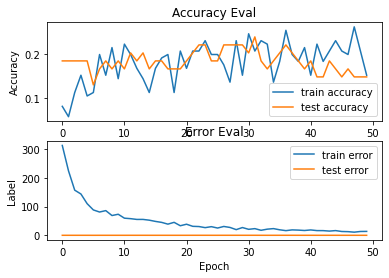

In [38]:
# Libraries
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt 

# CONSTANTS
DATASET_PATH ="./data-prueba.json"

# Load the data 
def load_data(dataset_path):
  with open(dataset_path, "r") as fp:
    data = json.load(fp)

    # convert lists into numpy array
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs, targets


inputs, targets = load_data(DATASET_PATH)

# Split the data into training and test 

x_train, x_test, y_train, y_test = train_test_split(inputs,targets, test_size=0.3)

# model 

model = keras.Sequential([
        keras.layers.Flatten(input_shape=(inputs.shape[1],inputs.shape[2] )) ,      
        keras.layers.Dense(512,activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256,activation="relu" , kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64,activation="relu" , kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(10,activation="softmax"),


])

def plot_history(history):
  figs, axs= plt.subplots(2)

  # accuracy subplot 

  axs[0].plot(history.history["accuracy"], label="train accuracy")
  axs[0].plot(history.history["val_accuracy"], label="test accuracy")
  axs[1].set_xlabel("Epoch")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title('Accuracy Eval') 



  axs[1].plot(history.history["loss"], label="train error")
  axs[1].plot(history.history["val_accuracy"], label="test error")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Label")

  axs[1].legend(loc="upper right")
  axs[1].set_title('Error Eval') 

  plt.show()

  # compilation 

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

history = model.fit(x_train,y_train, validation_data=(x_test,y_test), epochs=50, batch_size=32)


plot_history(history)

In [39]:
def prepare_datasets(test_size,val_size):
  X , y= load_data(DATASET_PATH)
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)
  
  return X_train, X_val, X_test ,y_train, y_val, y_test



In [40]:
def build_model(input_shape):
  """Generates RNN-LSTM Model
  :param input_shape(tuple): shape of input set
  :return model: RNN-LSTM Model """

  model = keras.Sequential()

  # 3 LSTM Layers

  model.add(keras.layers.LSTM(64,input_shape=input_shape, return_sequences=True))
  model.add(keras.layers.LSTM(64, return_sequences=True))
  model.add(keras.layers.LSTM(64))

  # dense layer
  model.add(keras.layers.Dense(64, activation="relu"))

  model.add(keras.layers.Dropout(0.2))


  #softmax output 
  model.add(keras.layers.Dense(7, activation="softmax"))
  return model

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 69, 64)            19968     
                                                                 
 lstm_37 (LSTM)              (None, 69, 64)            33024     
                                                                 
 lstm_38 (LSTM)              (None, 64)                33024     
                                                                 
 dense_38 (Dense)            (None, 64)                4160      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_39 (Dense)            (None, 7)                 455       
                                                                 
Total params: 90,631
Trainable params: 90,631
Non-tra

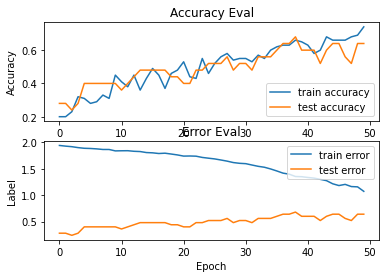

Target: 3, predicted label: [3]


In [45]:
if __name__ == "__main__":
  X_train, X_val, X_test ,y_train, y_val, y_test = prepare_datasets(0.3, 0.2)

  # model 
  input_shape = (X_train.shape[1], X_train.shape[2] )

  model = build_model(input_shape)

  # compilation
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)

  model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  model.summary()
  history = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=32, epochs=50)

  # evaluate 

  test_error, test_accuracy = model.evaluate(X_test,y_test, verbose=1)

  print(f"Accuracy on test set is: {test_accuracy}")
  print(f"Error on test set is: {test_error}")


  plot_history(history)


  X = X_test[25]
  y= y_test[25]
  predict(model,X,y)